## Цели и задачи проекта

**Целью** проекта является проведение статистического теста для проверки гипотезы, выдвинутой командой сервиса электронной библиотеки, заключающуюся в том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы. 

       
Для достижения цели поставлены следующие **задачи**:
* сформулировать нулевую и альтернативную гипотезы,
* определить целевую метрику, тип теста и его параметры, 
* провести тест и оценить корректность его проведения,
* проанализировать результаты теста,
* сделать выводы и предположения о причинах полученных результатов.

## Описание данных

Для работы имеется в распоряжении файл */datasets/yandex_knigi_data.csv*, содержащий информацию о пользователях сервиса из Москвы и Санкт-Петербурга.
Файл содержит следующие поля:

- *city* — город пользователя;
- *puid* — идентификатор пользователя;
- *hours* — общее количество часов активности.


## Содержимое проекта

Для достижения цели и выполнения задач необходимо выполнить следующие основные шаги:
- Загрузка данных и знакомство с ними,
- Проверка гипотезы,
- Подготовка аналитической таблицы.


## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [116]:
# Импортируем библиотеку
import pandas as pd

# Импортируем библиотеку
import matplotlib.pyplot as plt

# Импортируем библиотеку
!pip install matplotlib-venn -q
from matplotlib_venn import venn2, venn2_circles
# Импортируем библиотеки для проведения стат.тестов
import scipy
from scipy.stats import mannwhitneyu

from math import *

In [117]:
# Выгружаем данные

yandex_knigi_data = pd.read_csv(PATH + 'yandex_knigi_data.csv') 

In [118]:
# Выводим на экран первые пять строк полученного датафрейма
yandex_knigi_data.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [119]:
# Выводим информацию о датафрейме
yandex_knigi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


Датасет yandex_knigi_data содержит 8784 строки и 4 колонки. Пропуски в полях отсутсвуют. Типы данных выбраны корректно.

In [120]:
# Проверяем дубликаты пользователей в Москве
yandex_knigi_data[yandex_knigi_data['city']=='Москва'].duplicated(subset='puid').sum()

0

In [121]:
# Проверяем дубликаты пользователей в Санкт-Петербурге
yandex_knigi_data[yandex_knigi_data['city']=='Санкт-Петербург'].duplicated(subset='puid').sum()

0

Дубликаты пользователей внутри групп отсутствуют.

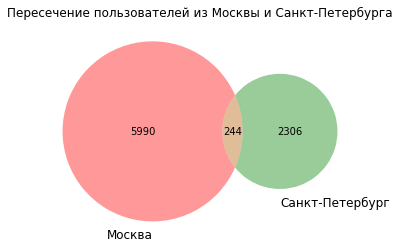

In [122]:
# Строим диаграмму Венна для проверки и визуализации пересечений пользователей 
# из Москвы и Санкт-Петербурга
A1=set(yandex_knigi_data[yandex_knigi_data['city']=='Москва']['puid'])
B1=set(yandex_knigi_data[yandex_knigi_data['city']=='Санкт-Петербург']['puid'])
venn2([A1, B1], set_labels=('Москва', 'Санкт-Петербург'))
# Отображаем график
plt.title("Пересечение пользователей из Москвы и Санкт-Петербурга")
plt.show()

In [123]:
# Применяем метод intersection для выявления количества пересечений
len(A1.intersection(B1))

244

График показывает, что 244 пользователя присутсвуют в обоих группах. Исключим их из обоих групп.

In [124]:
#Сохраним список идентификаторов пользователей из пересечения данных
users_del=A1.intersection(B1)

In [125]:
# Пересохраним датасет без пересекающихся данных
yandex_knigi_data=yandex_knigi_data[~yandex_knigi_data['puid'].isin(users_del)].reset_index(drop=True)

Для оценки распределения построим диаграмму размаха и гистограмму для количества часов активности пользователей.

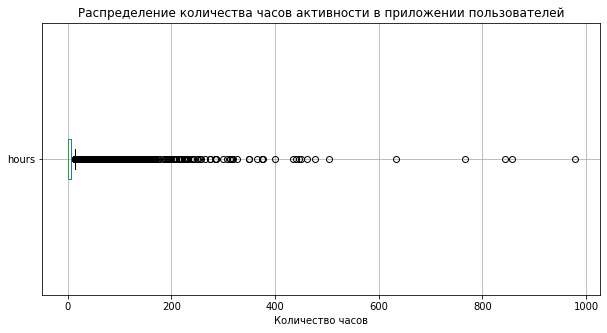

In [126]:
# Строим диаграмму размаха значений
plt.figure(figsize=(10, 5))
yandex_knigi_data.boxplot(column='hours', vert=False)
plt.title('Распределение количества часов активности в приложении пользователей')
plt.xlabel('Количество часов')
plt.show()

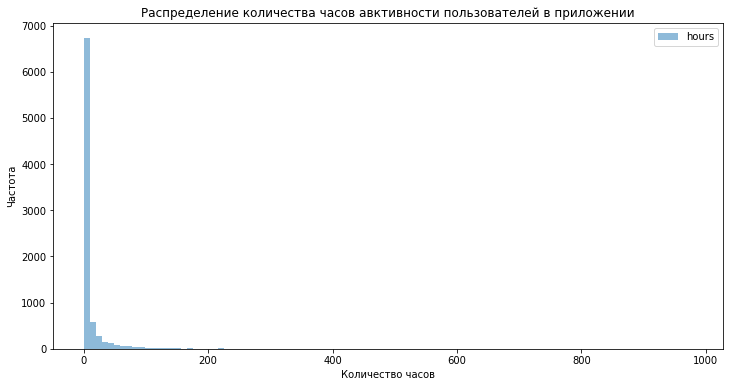

In [127]:
# Строим гистограмму распределения количества активности пользователей приожения

# Создаём фигуру графика
plt.figure(figsize=(12, 6))

# Строим гистограмму
yandex_knigi_data['hours'].plot(
        kind='hist',
        bins=100,
        alpha=0.5,
        legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение количества часов авктивности пользователей в приложении')
plt.xlabel('Количество часов')
plt.ylabel('Частота')
plt.legend()
plt.show()

На диаграммах размаха видно, что распределение количества часов активности пользователей приложения имеет правостороннюю асимметрию и значительные выбросы в правой части графика. Это может быть обусловлено техническими неполадками. Поэтому избавимся от них, оставив значения не более 95%-го перцентиля.

In [128]:
#Сохраним данные о часах активности пользователей, ограниченные 95% перцентилем
yandex_knigi_data1 = yandex_knigi_data[(yandex_knigi_data['hours'] <= yandex_knigi_data['hours'].quantile(0.95))]

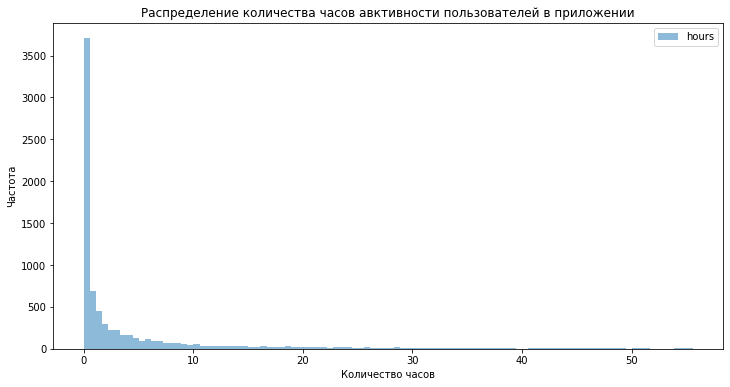

In [129]:
# Строим гистограмму распределения количества активности пользователей приожения 
# после очистки данных

# Создаём фигуру графика
plt.figure(figsize=(12, 6))

# Строим гистограмму
yandex_knigi_data1['hours'].plot(
        kind='hist',
        bins=100,
        alpha=0.5,
        legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Распределение количества часов авктивности пользователей в приложении')
plt.xlabel('Количество часов')
plt.ylabel('Частота')
plt.legend()
plt.show()

После фильтрации распределение часов активности пользователей в приложении стало более аккуратным, избавлено от аномально больших выбросов. 

Сравним группы из Москвы и Санкт-Петербурга по количеству пользователей.

In [130]:
# Рассчитываем и сохраняем количество уникальных пользователей в городах
A=yandex_knigi_data1[yandex_knigi_data1['city']=='Москва']['puid'].count()
B=yandex_knigi_data1[yandex_knigi_data1['city']=='Санкт-Петербург']['puid'].count()

In [131]:
# Рассчитываем и сохраняем процентную разницу в 
# количестве пользователей в группах A и B
P=fabs(A-B)*100/A
P

61.542515811665496

Проверим, как распределены часы активности пользователей между городами. Построим графики плотности вероятности для каждого города.

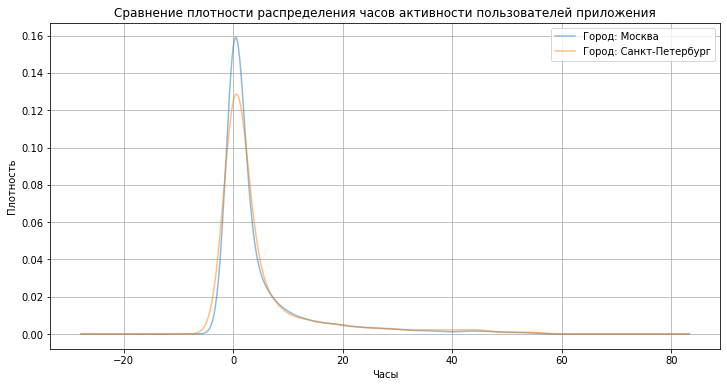

In [132]:
# Строим гистограмму распределения часов активности пользователей в Москве и Санкт-Петербурге
column = 'hours'

# Создаём фигуру графика
plt.figure(figsize=(12, 6))

# Строим гистограммы для каждого значения city
for i in yandex_knigi_data1['city'].unique():
    # Фильтруем данные по значению столбца city
    yandex_knigi_data1.loc[yandex_knigi_data1['city'] == i, column].plot(
        kind='kde',
        alpha=0.5,
        label=f'Город: {i}',
        legend=True, 
        grid=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение плотности распределения часов активности пользователей приложения')
plt.xlabel('Часы')
plt.ylabel('Плотность')
plt.legend()
plt.show()

На графике видно, что несмотря на различие в количестве пользователей в каждой из групп, плотность вероятности часов активности пользователей распределено одинаково. В пиковой зоне есть небольшой перевес в сторону пользователей из Москвы, но различие незначительное, им можно пренебречь. 

И в соответсвии с проведенными проверками, дополнительную выборку из пользователей города Москвы для обеспечения равенства групп по количеству пользователей проводить не требуется.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Необходимо статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Целевой метрикой является среднее количество времени, проведенное пользователями за чтением и прослушиванием книг в приложении. Рассчитаем целевую метрику, количество пользователей  и дисперсию по показателям для каждого города.

In [133]:
# Рассчитаем статистики данных по городам
yandex_knigi_data1.groupby('city').agg(
   mean_hours=('hours', 'mean'),  
    users_count=('puid','count'), 
    var_hours=('hours','var'))

,mean_hours,users_count,var_hours
city,,,
Москва,4.641440,5692,82.177375
Санкт-Петербург,4.971759,2189,96.687386


In [134]:
# Рассчитываем разницу в средних значениях часов активности 
# пользователей приложения из Москвы и Санкт-Петербурга
avg_msc=yandex_knigi_data1[yandex_knigi_data1['city']=='Москва']['hours'].mean()
avg_spb=yandex_knigi_data1[yandex_knigi_data1['city']=='Санкт-Петербург']['hours'].mean()

(1-avg_spb/avg_msc)*100

-7.116738666209188

Сравнение показвает, что среднее значениях часов активности пользователей приложения из Санкт-Петербурга на 7% больше, чем у пользователей из Москвы. Чтобы проверить, является ли это изменение статистически значимым, необходимо провести статистический тест. 

In [135]:
# Задаём уровень значимости
alpha = 0.05  

In [136]:
# Сохраняем выборки количества часов активности пользователей приложения 
# в Москве и Санкт-Петербурге 
msc=yandex_knigi_data[yandex_knigi_data['city']=='Москва']['hours']
spb=yandex_knigi_data[yandex_knigi_data['city']=='Санкт-Петербург']['hours']

In [137]:
# Сохраняем выборки количества часов активности пользователей приложения 
# в Москве и Санкт-Петербурге у фильтрованных очищенных данных
msc1=yandex_knigi_data1[yandex_knigi_data1['city']=='Москва']['hours']
spb1=yandex_knigi_data1[yandex_knigi_data1['city']=='Санкт-Петербург']['hours']

Проведем тест Шапиро-Уилка для проверки нормальности распределения часов активности пользователей.

Сформулируем нулевую и альтернативную гипотезу для теста Шапиро-Уилка для пользователей приложения из Москвы:

*Нулевая гипотеза H₀*: Распределение часов активности пользователей приложения из Москвы является нормальным.

*Альтернативная гипотеза H₁*: Распределение часов активности пользователей приложения из Москвы не является нормальным.

In [138]:
# тест Шапиро-Уилка для Москвы
stat1_shapiro, p1_shapiro = scipy.stats.shapiro(msc1) 
print('Statistics=%.3f, p-value=%.3f' % (stat1_shapiro, p1_shapiro))

if p1_shapiro > alpha:
    print('Распределение часов активности пользователей приложения из Москвы является нормальным.')
else:
    print('Распределение часов активности пользователей приложения из Москвы не является нормальным.')

Statistics=0.566, p-value=0.000
Распределение часов активности пользователей приложения из Москвы не является нормальным.


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Сформулируем нулевую и альтернативную гипотезу для теста Шапиро-Уилка для пользователей приложения из Санкт-Петербурга:

*Нулевая гипотеза H₀*: Распределение часов активности пользователей приложения из Санкт-Петербурга является нормальным.

*Альтернативная гипотеза H₁*: Распределение часов активности пользователей приложения из Санкт-Петербурга не является нормальным.

In [139]:
# тест Шапиро-Уилка для Санкт-Петербурга
stat2_shapiro, p2_shapiro = scipy.stats.shapiro(spb1) 
print('Statistics=%.3f, p-value=%.3f' % (stat2_shapiro, p2_shapiro))

if p2_shapiro > alpha:
    print('Распределение часов активности пользователей приложения из Санкт-Петербурга является нормальным.')
else:
    print('Распределение часов активности пользователей приложения из Санкт-Петербурга не является нормальным.')

Statistics=0.562, p-value=0.000
Распределение часов активности пользователей приложения из Санкт-Петербурга не является нормальным.


Тест показал, что распределение не является нормальным, но предпосылкой для использования т-теста является нормальность распределения выборочного среднего. Нужно проверить нормальность распределения средних в выборке. Для этого мы можем использовать тест Шапиро — Уилка. Однако нам нужно много выборок, чтобы убедиться в том, что среднее значение в них действительно распределено нормально. Выделим из наших данных 1000 выборок и посчитаем для каждой среднее значение.
Для этого мы напишем цикл while, который запустим 1000 раз. Для этого будем считать с помощью переменной n количество итераций цикла. Когда она станет равна 1000 — остановимся.
Внутри цикла мы каждый раз будем случайным образом брать 100 случайных значений и вычислять их среднюю оценку. Получившийся результат запишем в список. Проведем тест отдельно для пользователей Москвы и Санкт-Петербурга.


Сформулируем нулевую и альтернативную гипотезу для теста Шапиро-Уилка для пользователей приложения из Москвы:

Нулевая гипотеза H₀: Выборочное среднее часов активности пользователей приложения из Москвы имеет нормальное распределение.

Альтернативная гипотеза H₁: Распределение выборочного среднего часов активности пользователей приложения из Москвы не является нормальным.

In [140]:
# тест Шапиро-Уилка для выборочных средних часов активности пользователей Москвы
means_fic1 = []
n1 = 0

while n1 < 1000:
    n1 += 1
    sample1 = msc1.sample(100).mean()
    means_fic1.append(sample1)
    
stat_shapiro1, p_shapiro1 = scipy.stats.shapiro(means_fic1) 
print('Statistics=%.3f, p-value=%.3f' % (stat_shapiro1, p_shapiro1))

if p_shapiro1 > alpha:
    print('Выборочное среднее часов активности пользователей приложения из Москвы имеет нормальное распределение.')
else:
    print('Распределение выборочного среднего часов активности пользователей приложения из Москвы не является нормальным.')

Statistics=0.995, p-value=0.001
Распределение выборочного среднего часов активности пользователей приложения из Москвы не является нормальным.


Сформулируем нулевую и альтернативную гипотезу для теста Шапиро-Уилка для пользователей приложения из Санкт-Петербурга:

Нулевая гипотеза H₀: Выборочное среднее часов активности пользователей приложения из Санкт-Петербурга имеет нормальное распределение.

Альтернативная гипотеза H₁: Распределение выборочного среднего часов активности пользователей приложения из Санкт-Петербурга не является нормальным.

In [141]:
# тест Шапиро-Уилка для выборочных средних часов активности пользователей Санкт-Петербурга
means_fic2 = []
n2 = 0

while n2 < 1000:
    n2 += 1
    sample2 = spb1.sample(100).mean()
    means_fic2.append(sample2)
    
stat_shapiro2, p_shapiro2 = scipy.stats.shapiro(means_fic2) 
print('Statistics=%.3f, p-value=%.3f' % (stat_shapiro2, p_shapiro2))

if p_shapiro2 > alpha:
    print('Выборочное среднее часов активности пользователей приложения из Санкт-Петербурга имеет нормальное распределение.')
else:
    print('Распределение выборочного среднего часов активности пользователей приложения из Санкт-Петербурга не является нормальным.')


Statistics=0.995, p-value=0.001
Распределение выборочного среднего часов активности пользователей приложения из Санкт-Петербурга не является нормальным.


Сформулируем нулевую и альтернативную гипотезу для теста Левена:

Нулевая гипотеза H₀: Дисперсии количества часов активности пользователей приложения в Москве и Санкт-Петербурге равны.

Альтернативная гипотеза H₁: Дисперсии количества часов активности пользователей приложения в Москве и Санкт-Петербурге различаются, и это различие статистически значимо.

In [142]:
#тест Левена для проверки равенства дисперсий
test_leven, p_leven = scipy.stats.levene(msc1, spb1)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p_leven))
if p_leven < alpha:
    print('Дисперсии количества часов активности пользователей приложения в Москве и Санкт-Петербурге различаются, и это различие статистически значимо.')
else:
    print('Дисперсии количества часов активности пользователей приложения в Москве и Санкт-Петербурге равны.')

Statistics=2.087, p-value=0.149
Дисперсии количества часов активности пользователей приложения в Москве и Санкт-Петербурге равны.


Еще раз пропишем гипотезы для теста:

Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [143]:
# Проводим тест Манна — Уитни
mw_test = mannwhitneyu(
    msc,
    spb,
    alternative='less'
)

In [144]:
# Интерпретируем результаты
if  mw_test.pvalue>alpha: 
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')

pvalue=0.4532273739367588 > 0.05
Нулевая гипотеза находит подтверждение! Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


В ходе исследования проведены проверки на выполнение условий для применения t-теста. С помощью теста Шапиро проведены проверки на нормальность выборочных средних, в результате которых выявлено, что назвать распределение нормальным нельзя. Таким образом, для проверки гипотезы выбран тест Манна-Уитни, который показал, что нулевую гипотезу отвергнуть не получается. То есть средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

## 3. Аналитическая записка


Для проверки гипотезы, выдвинутой командой сервиса электронной библиотеки, заключающуюся в том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы, был проведен статистический А/В тест.

В качестве целевой метрики используется среднее количество времени, проведенное пользователями за чтением и прослушиванием книг в приложении.

Ввиду того, что не соблюдается условие нормальности выборочного распределения, для проверки использован не t-тест Уэлча, а непараметрический тест Маннта-Уитни.

Для проведения теста выбран уровень значимости — 0.05.

Тест показал значение pvalue=0.45, что больше установленного уровня значимости. 

Следовательно, альтернативная гипотеза не находит подтверждение, и средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


То есть несмотря на то, что среднее значение часов активности пользователей приложения из Санкт-Петербурга выше, чем в Москве, статистический тест это не подтвердил. Такой результат может быть обусловлен тем, что существуют отдельные пользователи из Санкт-Петербурга с более высоким показателем количества активных часов, что завышает среднее, но не является правилом.

----